In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [1]:
import pandas as pd
from glob import glob
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.cloud import storage

## Functions to read data and load it

In [2]:


def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

In [5]:
def loading_one_subject(subject_number):
    y_raw= []
    raw = []
    fnames =  sorted(glob('../raw_date/train/subj%d_series*_data.csv' % (subject_number)))
    for fname in fnames:
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
    X = pd.concat(raw).reset_index()
    X.drop(columns = 'index', inplace = True)
    y = pd.concat(y_raw).reset_index()
    y.drop(columns = 'index', inplace = True)
    return X, y

### Loading one subject

In [6]:
X, y = loading_one_subject(1)

## Function for mean absolute deviation of a signal and wavelet_denoising

In [7]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [8]:
def wavelet_denoising(X, wavelet='db2', level=3):
    x =np.asarray(X.astype(float))
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

## Visualizing a signal before and after wavelet denoising

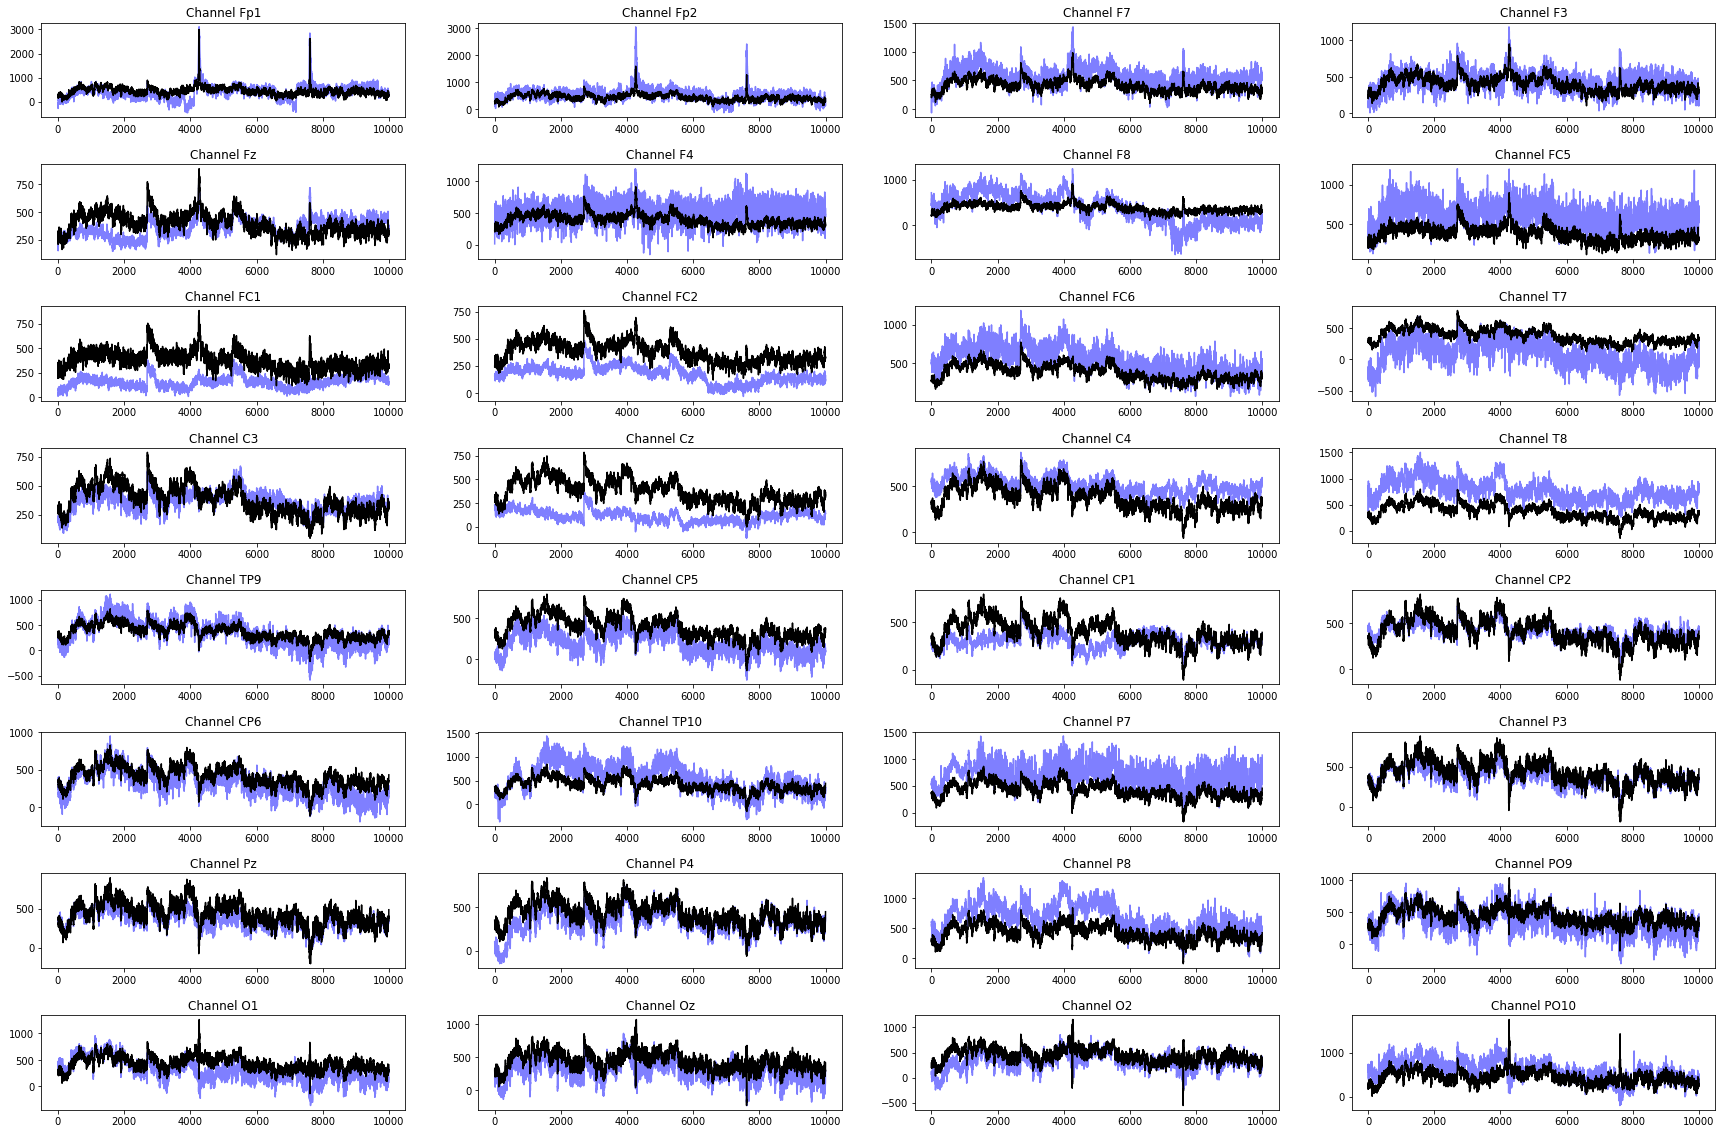

In [10]:
signal=pd.read_csv('../raw_date/train/subj1_series1_data.csv')
signal = signal.drop("id", axis=1)
filtered = wavelet_denoising(signal, wavelet='db2', level=3)
columns = signal.columns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  
  plt.plot(signal.iloc[:10000,i], label='signal', color="b", alpha=0.5,)
  plt.plot(filtered[:10000,i], label='reconstructed signal',color="k")
  #ax.legend(loc='upper left')
  ax.set_title(f'Channel {columns[i]}')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.show()

In [18]:
def visuals(i):
    signal=pd.read_csv('../raw_date/train/subj1_series1_data.csv')
    signal = signal.drop("id", axis=1)
    filtered = wavelet_denoising(signal, wavelet='db2', level=3)
    columns = signal.columns
    plt.figure(figsize=(25,15))

    plt.plot(signal.iloc[:10000,i], label='signal', color="b", alpha=0.5,)
    plt.plot(filtered[:10000,i], label='reconstructed signal',color="k")
    #ax.legend(loc='upper left')
    plt.title(f'Channel {columns[i]}')

    return plt.show()

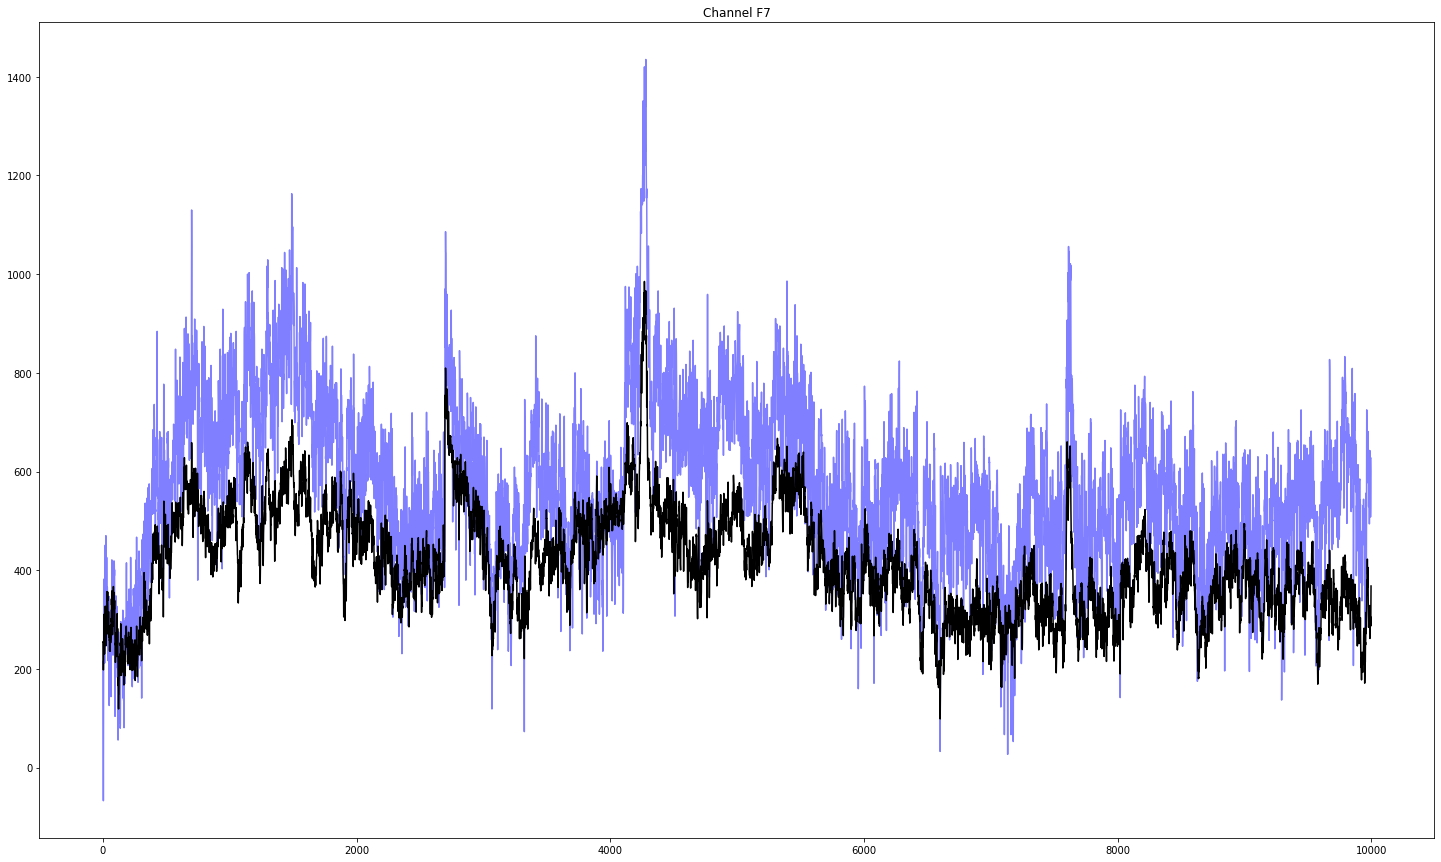

In [19]:
visuals(2)

In [11]:
X_ = wavelet_denoising(X, wavelet='db2', level=3)
X_ = pd.DataFrame(X_)
X_.columns = columns

In [12]:
eeg_channels = columns
labels = y.columns
train_set_complete = pd.concat([X_, y], axis=1)

train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()

,order,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,274.329072,264.283876,254.518137,245.031855,235.470692,226.188986,216.832400,207.400933,197.989531,243.749800,274.726864,290.920724,311.075731,316.447534,325.780484,339.074582,351.307294,348.113810,349.053763,354.127152,358.092991,366.192266,373.183990,379.068163,385.249104,352.727514,330.576235,318.795269,304.235586,300.046214,293.078126,283.331322,0,0,0,0,0,0
1,1,260.244981,258.660343,255.144905,249.698667,244.769785,237.910104,231.567779,225.742810,219.779216,257.501796,283.518701,297.829931,315.277687,321.019768,329.898375,341.913508,353.088212,344.902124,341.903745,344.093074,344.892361,350.879356,355.476309,358.683219,362.262591,334.310737,314.807650,303.753329,290.435167,285.565772,278.432537,269.035462,0,0,0,0,0,0
2,2,216.020660,231.073851,238.917498,239.551599,242.117493,237.473841,234.761981,233.981912,232.684222,255.723906,272.242410,282.239734,293.984403,299.207892,306.178726,314.896906,323.146885,322.859954,324.860481,329.148467,332.823530,338.786051,344.135650,348.872326,353.773234,315.967289,289.604611,274.685200,256.699575,250.157216,240.548643,227.873857,0,0,0,0,0,0
3,3,160.046594,189.501871,206.372364,210.658074,218.315866,213.388875,211.833966,213.651140,214.564767,238.481630,256.234795,267.824261,281.065285,288.142610,296.871494,307.251935,317.189843,318.772851,322.594547,328.654932,334.115463,341.814682,348.914046,355.413556,362.073796,307.118648,268.673294,246.737733,220.378386,210.528833,196.255494,177.558369,0,0,0,0,0,0
4,4,150.635753,181.006913,198.056139,201.783433,209.080328,203.055289,200.599852,201.714016,201.871709,239.345751,266.820907,284.297177,304.452641,314.609219,327.444990,342.959955,357.757032,346.031686,341.413001,343.900979,344.484732,352.175147,357.961338,361.843304,366.235506,310.115651,270.209953,246.518411,218.482300,206.660345,190.493820,169.982724,0,0,0,0,0,0


In [13]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1

HandStart = red
FirstDigitTouch = purple
BothStartLoadPhase = black
LiftOff = green
Replace = yellow
BothReleased = blue


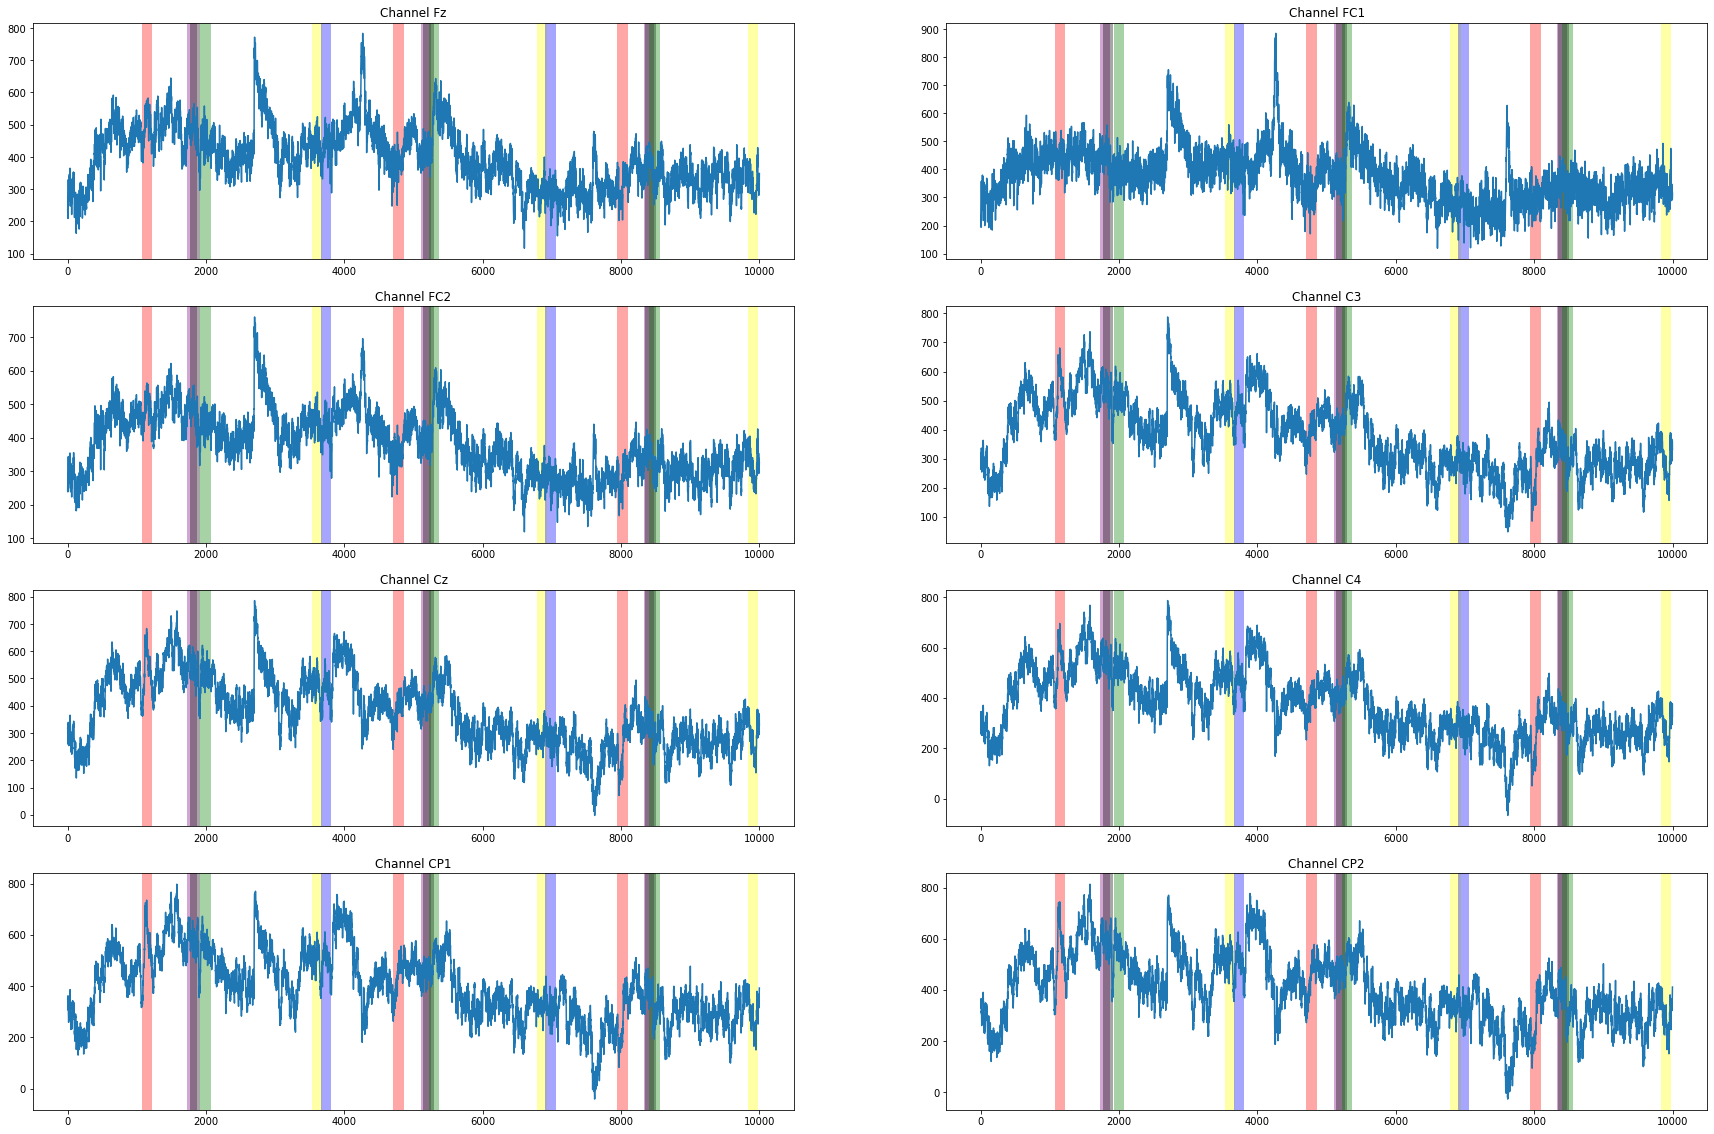

In [59]:
secondsToShow = 20
channelsToShow = 3
labelsToShow = 6


sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].set_index("order") #sample rate is 500hz 
colors=["red","purple","black","green", "yellow", "blue"]
motor_cortex = [4, 8, 9, 12, 13, 14, 18, 19]
axes = []
count = 1
plt.figure(figsize= (30, 20))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
for i in motor_cortex:
  colorindex = 0
  ax = plt.subplot(4, 2, count)
  plt.plot(sample_set[eeg_channels[i]])
  #axes.append((sample_set.plot(y=eeg_channels[i],subplots=True)[0]))
  ax.set_title(f'Channel {eeg_channels[i]}')
  for label in labels[:labelsToShow]:
      highlight(sample_set[sample_set[label]==1].index, ax, colors[colorindex])        
      colorindex = colorindex + 1
  count +=1

In [60]:
#for axis in axes:    
#  colorindex = 0
#  for label in labels[:labelsToShow]:
#      highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
#      colorindex = colorindex + 1

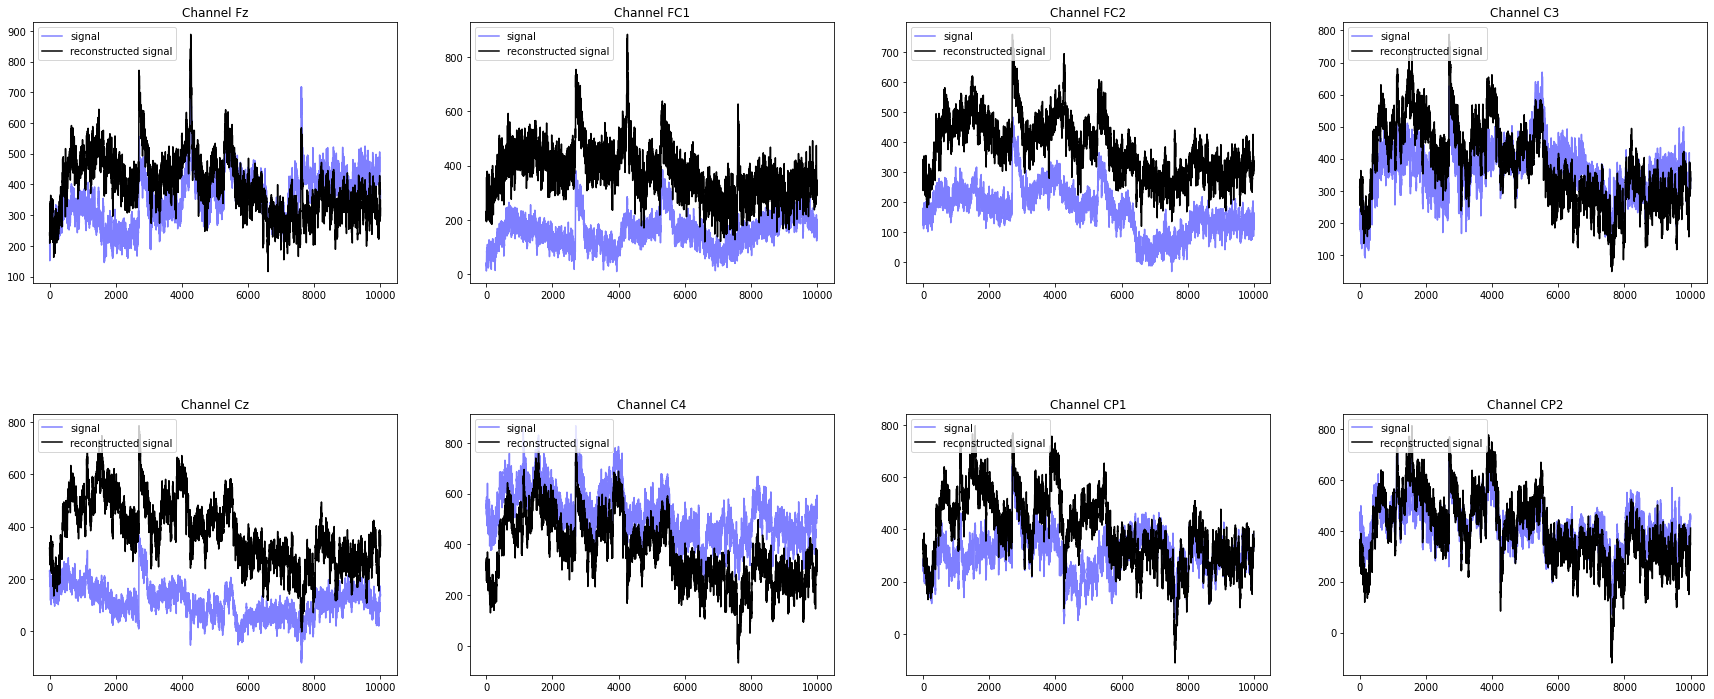

In [68]:
motor_cortex = [4, 8, 9, 12, 13, 14, 18, 19]
count = 1
plt.figure(figsize=(30,12))
for i in motor_cortex:
  
  ax = plt.subplot(2, 4, count)
  
  plt.plot(signal.iloc[:10000,i], label='signal', color="b", alpha=0.5,)
  plt.plot(filtered[:10000,i], label='reconstructed signal',color="k")
  ax.legend(loc='upper left')
  ax.set_title(f'Channel {columns[i]}')
  count += 1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.show()

## Scaling data

In [62]:
scaler= StandardScaler()
def data_scaler_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_scaler_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

## Test splitting data

In [65]:
def custom_train_test_split(X, y):   
    x_train_butter=wavelet_denoising(X)
    x_train=data_scaler_train(x_train_butter)

    splitrate=-x_train.shape[0]//5*2
    xval=x_train[splitrate:splitrate//2]
    yval=y[splitrate:splitrate//2]
    xtest=x_train[splitrate//2:]
    ytest=y[splitrate//2:]
    xtrain=x_train[:splitrate]
    ytrain=y[:splitrate]
    
    return xtrain, xval, xtest, ytrain, yval, ytest 

In [66]:
xtrain, xval, xtest, ytrain, yval, ytest = custom_train_test_split(X, y)